<a href="https://colab.research.google.com/github/FennicOculus/Image-translation/blob/main/Basic_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
import numpy as np

#Encoder

In [2]:
latentDim = 16
inputShape = (28, 28, 1)
chanDim = -1
depth = 1

In [3]:
inputs = Input(shape=inputShape)
x = inputs

x = Conv2D(16, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=3)(x)

x = Conv2D(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

volumeSize = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latentDim)(x)

In [4]:
encoder = Model(inputs, latent, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 16)        0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 32)          0         
                                                           

#Decoder

In [5]:
latentInputs = Input(shape=(latentDim,))
x = Dense(np.prod(volumeSize[1:]))(latentInputs)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

In [6]:
x = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2DTranspose(16, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

In [7]:
x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)

In [8]:
decoder = Model(latentInputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 1568)              26656     
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       9248      
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                           

In [9]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                30096     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         40865     
                                                                 
Total params: 70,961
Trainable params: 70,769
Non-trainable params: 192
_________________________________________________________________


#Spliting datasets

In [10]:
((trainX, _), (testX, _)) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [11]:
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

In [12]:
EPOCHS = 25
Batch_Size = 32

In [13]:
encoder.build(inputShape)
decoder.build(inputShape)
autoencoder.build(inputShape)

In [14]:
autoencoder.compile(loss="mse", optimizer=Adam(learning_rate=1e-3))

In [15]:
history = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=Batch_Size)

Epoch 1/25
1875/1875 [==============================] - 26s 7ms/step - loss: 0.0223 - val_loss: 0.0125
Epoch 2/25
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0114 - val_loss: 0.0102
Epoch 3/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 4/25
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 5/25
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 6/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 7/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 8/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0086 - val_loss: 0.0083
Epoch 9/25
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 10/25
1875/1875 [==============================] - 12s 6ms/step - l

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

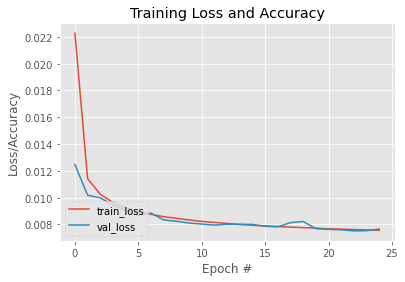

In [30]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [31]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
outputs = None

[INFO] making predictions...
313/313 [==============================] - 1s 3ms/step


In [32]:
decoded.shape

(10000, 28, 28, 1)

In [33]:
testX.shape

(10000, 28, 28, 1)

In [34]:
i = 1000

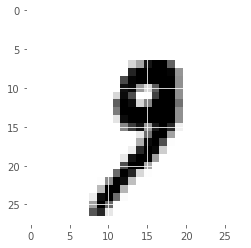

In [35]:
plt.imshow(testX[i], cmap=plt.cm.binary)

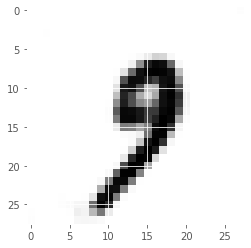

In [36]:
plt.imshow(decoded[i], cmap=plt.cm.binary)